# Thermostat

Example taken from: Chaudhuri, S., & Solar-Lezama, A. (2010, June). Smooth interpretation. In Proceedings of the 31st ACM SIGPLAN Conference on Programming Language Design and Implementation (pp. 279-291).

```
tOff = ?, tOn = ?

repeat {
    temp = readTemp()
    if isOn() and temp > tOff {
        isOn = False
    }
    else if not isOn() and temp < tOn {
        isOn = True
    }
}
```

Temperature evolves according to:
$$ \frac{d \textit{temp}}{dt} = \begin{cases} -k \cdot \textit{temp} + h \, (+ \text{gauss}(0, \epsilon)) & \text{if isON} \\
                                              -k \cdot \textit{temp} \, (+ \text{gauss}(0, \epsilon)) & \text{is not isOn}  \end{cases} $$

I generate temperature trajectories for $tOn =, tOff=, k=, h=, \epsilon=$ and try to synthesize $tOn, tOff$ using as loss the log-likelihood over trajectories.

In [7]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *
from time import time

torch.set_default_dtype(torch.float64)

### Original model

In [8]:
def orig_model(T=10, init_T=17., tOn=18, tOff=20, k=0.01, h=0.5, eps=0.5):
    traj = torch.zeros(T)
    isOn = False
    traj[0] = 16.
    noise = distributions.Normal(torch.tensor(0.), torch.tensor(eps))
    
    for i in range(1,T):
        
        #update temperature
        if isOn:
            traj[i] = traj[i-1] -k*traj[i-1] + h + noise.rsample() 
        else:
            traj[i] = traj[i-1] -k*traj[i-1] + noise.rsample() 

        # update thermostat state
        if isOn and traj[i] > tOff:
            isOn = False
        elif not isOn and traj[i] < tOn:
            isOn = True
            
    return traj        

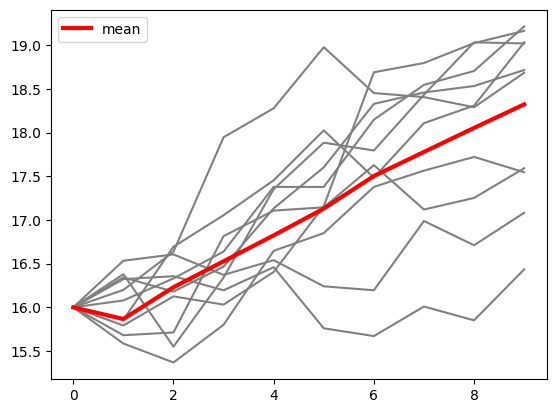

In [9]:
# generation of a set of trajectories

import matplotlib.pyplot as plt

traj_set = []
for _ in range(100):
    traj_set.append(orig_model())
traj_set = torch.vstack(traj_set)

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(10), traj_set[i], color='grey')

plt.plot(range(10), torch.mean(traj_set, 0), lw=3, color='red', label='mean')
plt.legend()

### SOGA program

In [17]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/Thermostat.soga')
cfg = produce_cfg(compiledFile)

pars = {'tOff':22., 'tOn':16.}

params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

output_dist = start_SOGA(cfg, params_dict)

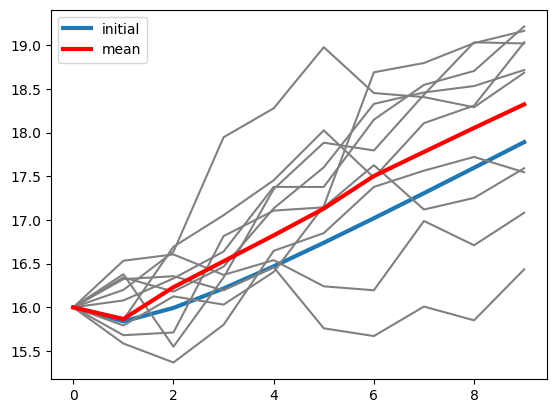

In [18]:
import matplotlib.pyplot as plt

y_init = output_dist.gm.mean()[:10].detach()
plt.plot(range(10), y_init, lw=3, label='initial')

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(10), traj_set[i], color='grey')

plt.plot(range(10), torch.mean(traj_set, 0), lw=3, color='red', label='mean')
plt.legend()

In [19]:
def neg_log_likelihood(traj_set, dist):
    idx = [1,2,3,4,5,6,7,8,9]
    log_likelihood = torch.log(dist.gm.marg_pdf(traj_set[:, idx], idx))
    return - torch.sum(log_likelihood)

def L2_distance(traj_set, dist):
    idx = [1,2,3,4,5,6,7,8,9]
    output_traj = dist.gm.mean()[idx]
    return torch.sum(torch.pow(traj_set[:, idx] - output_traj,2))

neg_log_likelihood(traj_set, output_dist)
        

tensor(696.8655, grad_fn=<NegBackward0>)

In [20]:
# Define the optimizer with init_mean as the parameter

from time import time
forward_time = []
loss_time = []
backward_time = []

#torch.autograd.set_detect_anomaly(True)

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.05)

total_start = time()

for i in range(50):

    optimizer.zero_grad()  # Reset gradients
    
    #with torch.autograd.set_detect_anomaly(True):
    # loss
    start = time()
    current_dist = start_SOGA(cfg, params_dict)
    end = time()
    forward_time.append(end-start)

    start = time()
    loss = neg_log_likelihood(traj_set, current_dist)
    end = time()
    loss_time.append(end-start)
        
    # Backpropagate
    start = time()
    loss.backward()
    end = time()
    backward_time.append(end-start)
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 10 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item()) + ' '
        out = out + f" loss: {loss.item()}"
        print(out)

total_end = time()

print('Optimization performed in ', round(total_end-total_start, 3))

print('Time for forward computation', torch.mean(torch.tensor(forward_time)))
print('Time for loss computation', torch.mean(torch.tensor(loss_time)))
print('Time for backward computation', torch.mean(torch.tensor(backward_time)))


tOff: 22.049999999756622 tOn: 16.049999999997855  loss: 696.8654593029033
tOff: 22.501234909208925 tOn: 16.481402786860606  loss: 648.2676128906892
tOff: 22.75444370330394 tOn: 16.738760226821483  loss: 642.6594749943903
tOff: 22.804026689621217 tOn: 16.88099992282952  loss: 641.5935788306517
tOff: 22.733056100062022 tOn: 16.94829945141699  loss: 641.4986422606416
Optimization performed in  75.933
Time for forward computation tensor(1.0457)
Time for loss computation tensor(0.0378)
Time for backward computation tensor(0.4344)


In [23]:
print('Total time for forward computation', torch.sum(torch.tensor(forward_time)))
print('Total time for loss computation', torch.sum(torch.tensor(loss_time)))
print('Total time for backward computation', torch.sum(torch.tensor(backward_time)))

Total time for forward computation tensor(52.2865)
Total time for loss computation tensor(1.8887)
Total time for backward computation tensor(21.7181)


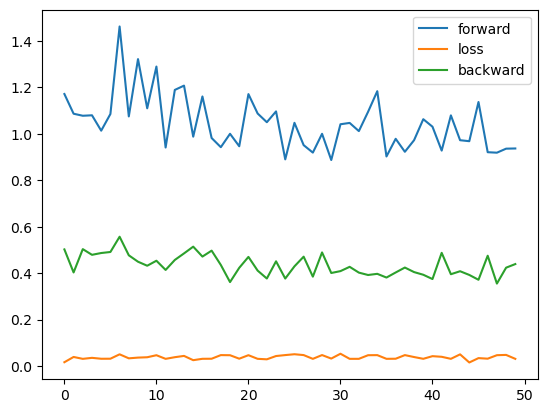

In [25]:
plt.plot(range(len(forward_time)), forward_time, label='forward')
plt.plot(range(len(loss_time)), loss_time, label='loss')
plt.plot(range(len(backward_time)), backward_time, label='backward')
plt.legend()

In [14]:
params_dict

{'tOff': tensor(22.5831, requires_grad=True),
 'tOn': tensor(16.9319, requires_grad=True)}

In [15]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/Thermostat.soga')
cfg = produce_cfg(compiledFile)
output_dist = start_SOGA(cfg, params_dict)

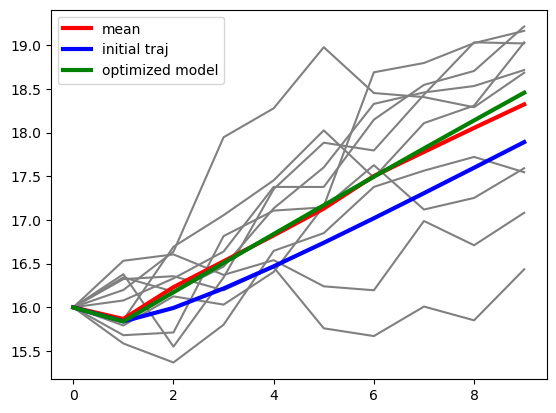

In [16]:
import matplotlib.pyplot as plt

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(10), traj_set[i], color='grey')

plt.plot(range(10), torch.mean(traj_set, 0), lw=3, color='red', label='mean')

plt.plot(range(10), y_init, lw=3, color='blue', label='initial traj')

plt.plot(range(10), output_dist.gm.mean()[:10].detach(), lw=3, color='green', label='optimized model')

plt.legend()